In [97]:
import sys
import requests
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk import Text
import pandas as pd
import re
from urllib.parse import quote   # 입력한 값을 바이너리 형식으로 변경
import json
from konlpy.tag import Okt
from tqdm import tqdm

### requests 모듈을 이용한 데이터 요청

In [98]:
def kin_request(encText, staPage=1):
    # url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # xml 결과
    url = "https://openapi.naver.com/v1/search/kin?query=" + quote(encText) # json 결과
    url = url + "&start=" + str(staPage) + "&display=100" 

    headers={"X-Naver-Client-Id": "lcoe8JHxFJLWXqdJjZsc",
             "X-Naver-Client-Secret":"wwrQCVxupt"}

    res_json =requests.get(url, headers=headers)

    if res_json.status_code==200:
        res_body = res_json.json()
    else:
        print("Error Code:" + str(res_json.status_code))
        sys.exit(0)

    res_body['items']
    res_df=pd.DataFrame(res_body['items'])  # items 키의 값들을 이용한 DataFrame 생성
    
    return list(res_df['link'])

### 세부 정보 가저오기
- res_df의 link 정보를 이용해 세부 내용 가져오기
- 질문 정보 => 키워드_질문.txt에 저장
- 답변 정보 => 키워드_답변.txt에 저장

#### 세부정보에서 질문 및 답변 추출후 텍스트로 저장 

In [99]:
def req_title(encText, staPage):
    
    link_list=kin_request(encText, staPage)
    
    fq=open('c:/pydata/'+encText+"_질문.txt", "a")
    fa=open('c:/pydata/'+encText+"_답변.txt", "a")
    
    for link in tqdm(link_list):
        kin_html=requests.get(link)
        if kin_html.status_code==200:
            kin_soup=bs(kin_html.text, "html.parser")
        else:
            sys.exit(kin_html.status_code)
        
        ### 제목 추출
        try:
            kin_txt=kin_soup.find('div', class_="title").text.replace("\n","").replace("\t","")
            fq.write(kin_txt+"\n")
        except:
            #print(link)
            fq.write("\n")
        
        for txt in kin_soup.find_all('div', class_="se-component se-text se-l-default"):
            # 정규 표현식을 이용해 한글, 영문등 필요한 내용만 가져오기: https://wikidocs.net/4308#_2 참조
            #fa.write(txt.text.replace("\u200b","").replace("\u2714",""))
            fa.write(re.sub("[^ ㄱ-ㅣ가-힣]","",txt.text))
        fa.write('\n')
        
    fq.close()
    fa.close()

In [116]:
### 질문 제목 가져와 키워드 추출하기
def title_counter():
    f=open('c:/pydata/'+encText+"_질문.txt", "r")
    title_txt=f.read()
    f.close()

    ### 가져온 데이터를 konlpy의 Okt를 이용해 품사 확인
    okt=Okt()    # okt 객체 생성
    pos_title=okt.pos(title_txt)
    #print(pos_title)

    noun_text=[ txt[0] for txt in pos_title if txt[1]=='Noun' ]
    adje_text=[ txt for txt, pos in pos_title if pos=='Adjective' ]

    most_text=noun_text+adje_text
    #print(most_text)

    stop_words="제주도 여행 중 부탁드립니다 데 부탁드려요"
    stop_words=stop_words.split(" ")
    #print(stop_words)

    most_stop=[txt for txt in most_text if txt not in stop_words]
    #print(most_stop)

    return Counter(most_stop)
    

In [131]:
def most_wordcloud(most_count):
    #### 워드 클라우드 제작
    wordcloud = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf",
                          background_color="white", width=1000, height=1000,
                          max_words=100, max_font_size=300)

    wc = wordcloud.generate_from_frequencies(most_count)
    plt.figure(figsize=(8,15))
    plt.imshow(wc)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    import matplotlib.font_manager as fm
    font_name=fm.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
    plt.rc('font', family=font_name)

    ### 빈도수 DataFrame 생성
    most_list=most_count.most_common()
    most_df=pd.DataFrame(most_list, columns=["토픽(단어)", "빈도수"])
    plt_df=most_df[most_df['빈도수']>=10]

    plt.style.use('ggplot') 
    plt_df.set_index("토픽(단어)", inplace=True)
    plt_df.plot.bar(figsize=(14, 5))
    plt.show()

    return most_df

In [101]:
encText=input('검색어 입력:')
staPage=input('시작 페이지:')

fq=open('c:/pydata/'+encText+"_질문.txt", "w");fq.close()
fa=open('c:/pydata/'+encText+"_답변.txt", "w");fa.close()

for stapg in range(int(staPage), 500, 100):
    req_title(encText, stapg)

most_count=title_counter()
most_df=fmost_wordcloud(most_count)
most_df

검색어 입력:제주도
시작 페이지:1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


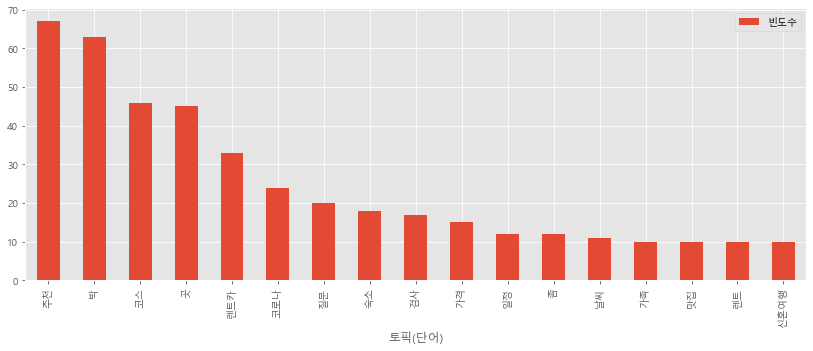

,빈도수
토픽(단어),
추천,67
박,63
코스,46
곳,45
렌트카,33
코로나,24
질문,20
숙소,18
검사,17
